## Note
Trying out different models and paramaters to see which performs the best

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [206]:
# Loading the evaluation data
df = pd.read_csv("../csv_files/development.csv")

In [207]:
## Reducing the dataset to X percent of original size to speed up model testing
# df = df.sample(frac=0.10)

In [208]:
## Filter out values outside 0.03 and 0.97 percentile 

# def filter_by_percentile(df, lower_quantile=0.03, upper_quantile=0.97):
#     for col in df.columns:
#         if col == "x" or col == "y":
#             continue
#         # Calculate the quantiles for each column
#         lower_bound = df[col].quantile(lower_quantile)
#         upper_bound = df[col].quantile(upper_quantile)

#         # Filter the DataFrame by the quantile range
#         df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

#     return df

# df = filter_by_percentile(df) ## Doesn't seem to work as is

# def limit_by_percentile(df, lower_quantile=0.03, upper_quantile=0.97):
#     for col in df.columns:
#         if col == "x" or col == "y":
#             continue

#         # Calculate the quantiles for each column
#         lower_bound = df[col].quantile(lower_quantile)
#         upper_bound = df[col].quantile(upper_quantile)

#         # Limit the DataFrame values by the quantile range
#         df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
#     return df

# df = limit_by_percentile(df)

In [209]:
# Extracting the positions, removes the x and y column and splitting the data into train and validation set
def extracting_positions(df):
    pos = []
    for i in range(len(df)):
        pos.append([df["x"].iloc[i], df["y"].iloc[i]])
    return pos

pos = extracting_positions(df)

## Dropping data from x and y 
df.drop(["x", "y"], axis=1, inplace=True)


In [210]:
## Removing pads with format: pads = ["0", "7", "12", ..]
def drop_pads(df, pads):
    cols_to_drop = [col for col in df.columns if any(idx in col for idx in pads)]
    df_removed = df.drop(cols_to_drop, axis=1)    
    return df_removed

remove_pads = ["0", "7", "12", "15", "16", "17"]
df_removed_noise = drop_pads(df, remove_pads)

In [211]:
## Removing rms feature
def drop_rms_features(df):
    # Extract columns that start with 'rms'
    rms_columns = [col for col in df.columns if not col.startswith('rms')]

    # Create a new DataFrame without 'rms' columns
    df_without_rms = df[rms_columns] 
    return df_without_rms

df_interesting_data = drop_rms_features(df_removed_noise)

In [212]:
## Adding an extra column where pmax and area are multiplied with each other
df_interesting_data['pmax_times_area_pad[5]'] = df_interesting_data["pmax[5]"] * df_interesting_data["area[5]"]

/var/folders/v9/41dk4qp51lvfpqp970zc01hr0000gn/T/ipykernel_76920/2401980542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interesting_data['pmax_times_area_pad[5]'] = df_interesting_data["pmax[5]"] * df_interesting_data["area[5]"]


In [213]:
## Splitting into train and validation set
X_train, X_val, pos_train, pos_val = train_test_split(df_interesting_data, pos, test_size=0.2, random_state=42)

## RandomForestRegressor

In [214]:
# RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import math
from sklearn.feature_selection import SelectFromModel

def avg_euc_dist(pos_val, pos_pred):
    sum_square = 0
    for i in range(len(pos_val)):
        sum_square += math.sqrt((pos_val[i][0]-pos_pred[i][0])**2 + (pos_val[i][1]-pos_pred[i][1])**2)
    return sum_square/len(pos_val) 


numb_trees = 25
base_regressor = RandomForestRegressor(n_estimators=numb_trees, criterion="poisson") 

# scaler = RobustScaler(quantile_range=(0.03, 0.97))
mult_regr = MultiOutputRegressor(base_regressor)

pipeline = Pipeline([
    # ('scaler', scaler),
    ('regressor', mult_regr),
])

pipeline.fit(X_train, pos_train)
pos_pred = pipeline.predict(X_val)

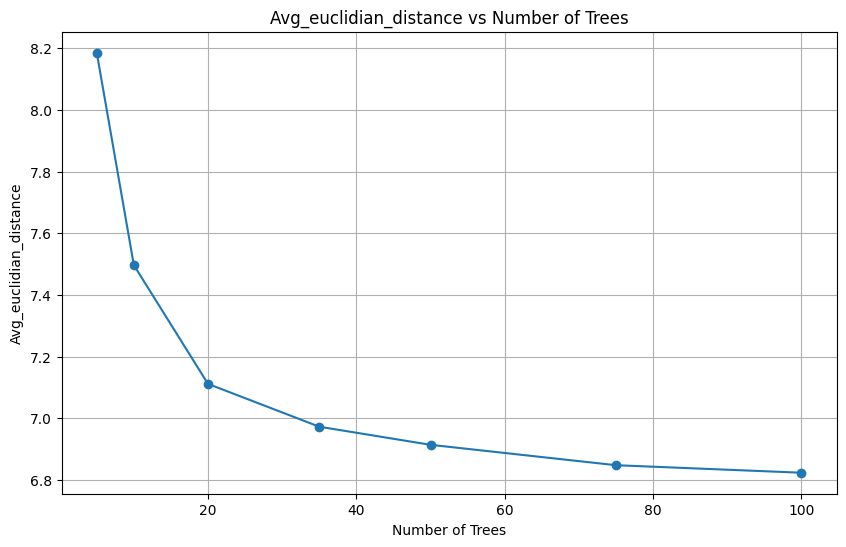

In [117]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
plt.plot(n_trees, performance_score, marker='o')  # 'o' creates circular markers at each data point
plt.title('Avg_euclidian_distance vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Avg_euclidian_distance')
plt.grid(True)
plt.show()

In [216]:
## Avg_euc_dist vs. numb of regression trees
## Should be run on ~10% of the data for the code to run within reasonable time. 

# import math
# def avg_euc_dist(pos_val, pos_pred):
#     sum_square = 0
#     for i in range(len(pos_val)):
#         sum_square += math.sqrt((pos_val[i][0]-pos_pred[i][0])**2 + (pos_val[i][1]-pos_pred[i][1])**2)
#     return sum_square/len(pos_val)   


# performance_score = []
# n_trees = [5, 10, 20, 35, 50, 75, 100]

# for i in n_trees:
#     print(i)
#     numb_trees = n_trees[i]
#     base_regressor = RandomForestRegressor(n_estimators=numb_trees)
#     mult_regr = MultiOutputRegressor(base_regressor)
#     mult_regr.fit(X_train, pos_train)
#     pos_pred = mult_regr.predict(X_val)
#     avg_dist = avg_euc_dist(pos_val, pos_pred)
#     performance_score.append(avg_dist)

    

In [215]:
# Metrics to evaluating model 
import sklearn.metrics as sm
import math
import numpy as np

def avg_euc_dist(pos_val, pos_pred):
    sum_square = 0
    for i in range(len(pos_val)):
        sum_square += math.sqrt((pos_val[i][0]-pos_pred[i][0])**2 + (pos_val[i][1]-pos_pred[i][1])**2)
    return sum_square/len(pos_val)        

def metrics_on_model(pos_val, pos_pred):
    print("Mean absolute error =", round(sm.mean_absolute_error(pos_val, pos_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(pos_val, pos_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(pos_val, pos_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(pos_val, pos_pred), 2)) 
    print("R2 score =", round(sm.r2_score(pos_val, pos_pred), 2))
    print("Mean eucledian distance =", round(avg_euc_dist(pos_val, pos_pred), 2))

metrics_on_model(pos_val, pos_pred)

Mean absolute error = 3.41
Mean squared error = 23.21
Median absolute error = 2.5
Explain variance score = 1.0
R2 score = 1.0
Mean eucledian distance = 5.42


## Results:

Test 1:  
    Data: reomving pads (0, 7, 12, 15, 16, 17)  
    Number of trees: 10   
    Mean euc dist: 5.77  

Test 2:  
    Data: reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature  
    Number of trees: 10  
    Mean euc dist: 5.69

Test 3:    
    Data: Sampeled 25% of the data to speed up model training. Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 10  
    Mean euc dist: 6.56  

Test 4:    
    Data: Sampeled 25% of the data to speed up model training. Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 30  
    Mean euc dist: 6.16  

Test 4:    
    Data: With PCA. Sampeled 25% of the data to speed up model training. Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 30  
    Mean euc dist: 10.29

Test 5:        
    Data: Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature. Added RobustScaling.   
    Number of trees: 50  
    Mean euc dist: 5.31  

Test 6:  
    Data: Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature. Added column: pmax[5]*area[5] 
    Number of trees: 30  
    Mean euc dist: 6.11

Test 7:   
    Data: Reomving pads (0, 7, 12, 15, 16, 17) and removing rms feature.  
    Number of trees: 30  
    Mean euc dist:  

 

## Using the multiple_reg_model on the evaluation set

In [217]:
ev_data = pd.read_csv("../csv_files/evaluation.csv")

In [218]:
# Extracting the ID
eval_id = ev_data["Id"]

# Dropping the Id column from the ev_data
ev_data.drop(["Id"], axis=1, inplace=True)

In [219]:
# Formatting the position array to a string to be used in the .csv file 
def pred_to_string(prediction_array):
    pred_column = []
    for i in range(len(prediction_array)):
        pos_string = (str(prediction_array[i][0]) + "|" + str(prediction_array[i][1]))
        pred_column.append(pos_string)
    return pred_column
        

In [220]:
remove_pads = ["0", "7", "12", "15", "16", "17"]
ev_data = drop_pads(ev_data, remove_pads)

In [221]:
ev_data = drop_rms_features(ev_data)

In [222]:
ev_data['pmax_times_area_pad[5]'] = ev_data["pmax[5]"] * ev_data["area[5]"]

In [223]:
# Predicting the evaluation results
mult_regr_eval = pipeline.predict(ev_data)
pos_pred = pred_to_string(mult_regr_eval) # Formatting the predictions 

In [224]:
# Creating a df and .csv file to be submitted. Saved in submission_file folder
mult_reg_submission = pd.DataFrame({'Id': eval_id, 'Predicted': pos_pred})
mult_reg_submission.to_csv("../DataScienceLab_Project/submission_files/mult_reg_rand_forest_with_added_feature.csv", index=False)